In [1]:
# Import required libraries for data manipulation and analysis
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

In [25]:
#Import required sklearn functions
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.inspection import permutation_importance

In [3]:
#Import sklearn classifiers
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [4]:
#Import library to oversample 
from imblearn.over_sampling import RandomOverSampler

In [5]:
#Import RDKit and Mordred libraries
from rdkit import Chem
from rdkit.Chem import Draw
from mordred import Calculator, descriptors

In [6]:
#Allows figures to be visualized in jupyter notebook
%matplotlib inline

In [7]:
# Sets Pandas Display to Monitor Code
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 15)

In [8]:
# Create Mordred Calculator
calc = Calculator(descriptors, ignore_3D=True)

In [35]:
# Read Training/Test data input File
data = pd.read_csv('BorylationTrainingTest_ParameterizedCats.csv')

In [36]:
# Assigns Reactants Mordred Info
reactants = data['Substrate']

reactants_mol_list = []
for inChi_reactants in reactants:
  reactants_mol = Chem.MolFromInchi(inChi_reactants)
  reactants_mol_list.append(reactants_mol)

reactants_img = Draw.MolsToGridImage(reactants_mol_list, molsPerRow=4)

/home/sweav003/envs/CHB/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:192: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


In [37]:
# Puts reactants into Pandas Type
reactant_data = []
reactant_data = calc.pandas(reactants_mol_list)
reactant_data.info()

100%|██████████| 680/680 [00:56<00:00, 11.94it/s]


<class 'mordred._base.pandas_module.MordredDataFrame'>
RangeIndex: 680 entries, 0 to 679
Columns: 1613 entries, ABC to mZagreb2
dtypes: bool(2), float64(900), int64(324), object(387)
memory usage: 8.4+ MB


In [38]:
#Joins Mordred parameters with experimental, atomic charges, and JChem for Excel parameters
add_reactants = pd.concat((data, reactant_data), axis=1)

In [39]:
#Force any non-numeric entries as NaN and replace them with 0
final_data = add_reactants.apply(pd.to_numeric, errors='coerce')
final_data.fillna(0, inplace=True)
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Columns: 1678 entries, Substrate to mZagreb2
dtypes: bool(2), float64(1325), int64(351)
memory usage: 8.7 MB


In [51]:
# Seperate dataset as response variable (Product Ratio) and feature variables
#Note: Product Ratio is described as "0" for non-borylating sites and "1" for borylating sites
X = final_data.drop('Product_Ratio' , axis = 1)
y = final_data['Product_Ratio']

In [52]:
#Remove any features that have zero variance, i.e. remain the same number for every entry
sel = VarianceThreshold()
_ = sel.fit(X)
mask = sel.get_support()
X = X.loc[:,mask]

In [53]:
#Remove any features that are greater than 95% correlated
corr_matrix = X.corr()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]

Final = X.drop(to_drop, axis = 1)
corr_matrix=Final.corr()

plt.figure(figsize = (10, 10),dpi=1000)
sns.heatmap(
    corr_matrix, 
    annot =False,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
   )

plt.show()

In [54]:
# Specifys Random Forest and the Number of Trees, SelectFromModel will
# select features which are most important
feature_names = [f"feature {i}" for i in range(Final.shape[1])]
forest = RandomForestClassifier(random_state=42)
forest.fit(Final, y)

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

threshold = np.sort(importances)[-100] 
sel = SelectFromModel(RandomForestClassifier(n_estimators = 800, max_depth=30),threshold=threshold)
sel.fit(Final, y)

# Select the final features set 
sel.get_support()
selected_feat= Final.columns[(sel.get_support())]

# Prints the names of the final selected features
print(selected_feat)

Index(['Hirshfeld Heavy Atom Charge', 'CM5 Charge', 'Hirshfeld Carbon Charge',
       'Hirshfeld Hydrogen Charge', 'ESP Heavy Atom Charge',
       'ESP Carbon Charge', 'ESP Hydrogen Charge', 'NPA Carbon Charge',
       'NPA Hydrogen Charge', 'MBS Carbon Charge', 'MBS Hydrogen Charge',
       'Mulliken Heavy Charge', 'Mulliken Carbon Charge',
       'Mulliken Hydrogen Charge', 'Steric Effect Index',
       'Atomic_Polarizability', 'Distance Degree', 'Dreiding Energy',
       'Eccentricity', 'Max Projection Area', 'Max Projection Radius', 'MaxZ',
       'Sigma Electronegativity', 'SpDiam_A', 'ATS0p', 'AATS2Z', 'AATS5i',
       'ATSC1d', 'AATSC2dv', 'AATSC3i', 'MATS2c', 'MATS5s', 'GATS5v', 'GATS5p',
       'BCUTd-1h', 'Xch-7dv', 'Xp-3dv', 'IC3', 'SIC0', 'CIC0', 'FilterItLogS',
       'AMID_C'],
      dtype='object')


In [55]:
#Create final dataframe for training and testing
final = X[selected_feat]

In [56]:
#Visualize the spearman correlation of the final features of dataset
corr_matrix = final.corr(method="spearman")

plt.figure(figsize = (10, 10),dpi=1000)
ax = sns.heatmap(
    corr_matrix, 
    annot =False,
    vmin=-1, vmax=1, center=0,
    cmap="YlGnBu",
    square=True,
    cbar_kws={'shrink': 0.82},
    annot_kws={"size": 5}  
   )

plt.show()

Elapsed time to compute the importances: 16.110 seconds


<Figure size 144x360 with 0 Axes>

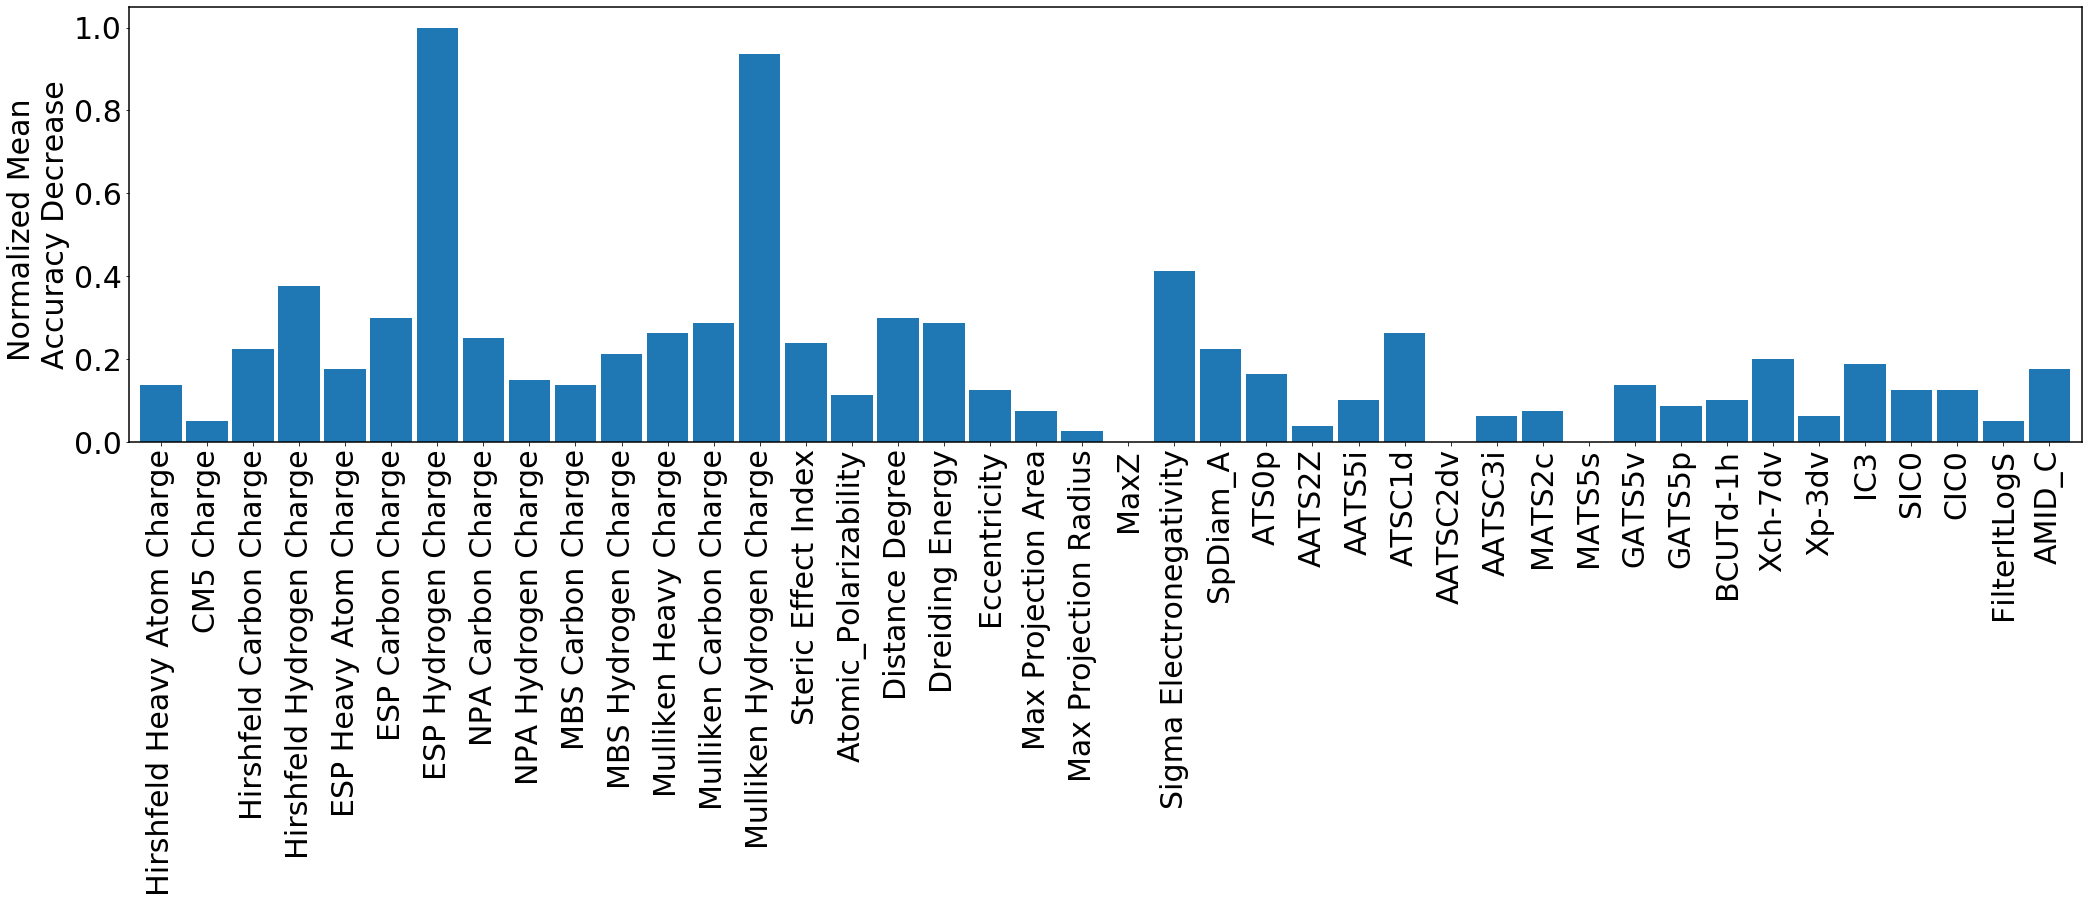

In [57]:
#Make a permutation plot on feature importance
feature_names = [f"feature {i}" for i in range(final.shape[1])]
forest = RandomForestClassifier(random_state=22, max_depth=5, n_estimators=800)
forest.fit(final, y)

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

start_time = time.time()
result = permutation_importance(
    forest, final, y, n_repeats=5, random_state=16, n_jobs=5
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index= selected_feat)

#Format data better
plot_df = forest_importances.to_frame()
plot_df.columns = ['importances']
plot_df.reset_index(inplace=True)
#print(plot_df)
plot_df_scaled = plot_df.copy()
column = 'importances'
plot_df_scaled[column] = plot_df_scaled[column] /plot_df_scaled[column].abs().max()
df_sort = plot_df_scaled.sort_values(by='importances', ascending= False)
#print(df_sort)

#Make Permutation Plot
plt.rcParams['axes.linewidth'] = 1.5 #set the value globally
fig = plt.figure(figsize=(2,5))
ax1 = plot_df_scaled.plot.bar(x = 'index', y = "importances",  width = 0.9, legend= False)
ax1.set_ylabel("Normalized Mean \nAccuracy Decrease")
ax1.set_xlabel('')
ax1.set_ylim(auto=True)
plt.rcParams["figure.figsize"] = (35,8)
plt.rcParams['font.size'] = '30'
plt.show()

In [59]:
#Apply catalyst parameters to the model
catParam = data[['Active Catalyst-Ligand','Catalyst','Ligand', 'ConeAngle','Buried_Vol','PyramidalizationAR',
                 'PyramidalizationG','SASA_area','SASA_vol','Sterimol_L','SterimolB_1','Sterimol_B_5']]

extra_feat_data = pd.concat((catParam, final), axis=1)
extra_feat_data

Active Catalyst-Ligand  Catalyst  Ligand   ConeAngle  Buried_Vol  \
0                         6         2       1  321.341999        14.9   
1                         6         2       1  321.341999        14.9   
2                         6         2       1  321.341999        14.9   
3                         6         2       1  321.341999        14.9   
4                         6         3       1  321.341999        14.9   
..                      ...       ...     ...         ...         ...   
675                       5         9       8  307.636321        24.0   
676                       5         9       8  307.636321        24.0   
677                       5         9       8  307.636321        24.0   
678                       5         9       8  307.636321        24.0   
679                       5         9       8  307.636321        24.0   

     PyramidalizationAR  PyramidalizationG  ...   Xch-7dv    Xp-3dv       IC3  \
0              0.683535          10.223844  ...  0.000000  1.457107  2.565448   
1              0.683535          10.223844  ...  0.000000  1.457107  2.565448   
2              0.683535          10.223844  ...  0.000000  1.457107  2.565448   
3              0.683535          10.223844  ...  0.000000  1.457107  2.565448   
4              0.683535          10.223844  ...  0.000000  2.483685  2.969973   
..                  ...                ...  ...       ...       ...       ...   
675            1.005836          10.008230  ...  0.027378  1.093794  3.794653   
676            1.005836          10.008230  ...  0.029926  1.213954  3.690117   
677            1.005836          10.008230  ...  0.029926  1.213954  3.690117   
678            1.005836          10.008230  ...  0.029926  1.213954  3.690117   
679            1.005836          10.008230  ...  0.029926  1.213954  3.690117   

         SIC0      CIC0  FilterItLogS    AMID_C  
0    0.189449  3.809948     -3.025802  1.853888  
1    0.189449  3.809948     -3.025802  1.853888  
2    0.189449  3.809948     -3.025802  1.853888  
3    0.189449  3.809948     -3.025802  1.853888  
4    0.194834  4.285038     -4.021809  1.730650  
..        ...       ...           ...       ...  
675  0.358091  2.676712     -1.514952  1.545960  
676  0.425558  2.348009     -2.308043  1.303694  
677  0.425558  2.348009     -2.308043  1.303694  
678  0.425558  2.348009     -2.308043  1.303694  
679  0.425558  2.348009     -2.308043  1.303694  

[680 rows x 54 columns]

In [65]:
#Loads validation dataset for borlation using the final reduced features 
unknownSubstrates=pd.read_csv('BorylationValidation_ParameterizedCatalysts.csv')

# Convert validation substrates Inchi's to Mordred and combine into Dataframe with atomic charges and JChem paramters
New_Substrate = unknownSubstrates['Substrate']
New_Substrate_mol_list = []
for inChi_New_Substrate in New_Substrate:
  New_Substrate_mol = Chem.MolFromInchi(inChi_New_Substrate)
  New_Substrate_mol_list.append(New_Substrate_mol)

New_Substrate_data = []
New_Substrate_data = calc.pandas(New_Substrate_mol_list)
New_Substrate_data = New_Substrate_data.apply(pd.to_numeric, errors='coerce')
New_Substrate_data.fillna(0, inplace=True)                                                                  
XnewSec = pd.concat((unknownSubstrates, New_Substrate_data), axis=1)
Xnew = XnewSec[selected_feat]

Xnew1 = XnewSec[['Active Catalyst-Ligand','Catalyst','Ligand', 'ConeAngle','Buried_Vol','PyramidalizationAR',
                 'PyramidalizationG','SASA_area','SASA_vol','Sterimol_L','SterimolB_1','Sterimol_B_5']]
unknown_extra = pd.concat((Xnew1, Xnew), axis=1)

100%|██████████| 79/79 [00:11<00:00,  7.09it/s]


In [66]:
unknown_extra.columns

Index(['Active Catalyst-Ligand', 'Catalyst', 'Ligand', 'ConeAngle',
       'Buried_Vol', 'PyramidalizationAR', 'PyramidalizationG', 'SASA_area',
       'SASA_vol', 'Sterimol_L', 'SterimolB_1', 'Sterimol_B_5',
       'Hirshfeld Heavy Atom Charge', 'CM5 Charge', 'Hirshfeld Carbon Charge',
       'Hirshfeld Hydrogen Charge', 'ESP Heavy Atom Charge',
       'ESP Carbon Charge', 'ESP Hydrogen Charge', 'NPA Carbon Charge',
       'NPA Hydrogen Charge', 'MBS Carbon Charge', 'MBS Hydrogen Charge',
       'Mulliken Heavy Charge', 'Mulliken Carbon Charge',
       'Mulliken Hydrogen Charge', 'Steric Effect Index',
       'Atomic_Polarizability', 'Distance Degree', 'Dreiding Energy',
       'Eccentricity', 'Max Projection Area', 'Max Projection Radius', 'MaxZ',
       'Sigma Electronegativity', 'SpDiam_A', 'ATS0p', 'AATS2Z', 'AATS5i',
       'ATSC1d', 'AATSC2dv', 'AATSC3i', 'MATS2c', 'MATS5s', 'GATS5v', 'GATS5p',
       'BCUTd-1h', 'Xch-7dv', 'Xp-3dv', 'IC3', 'SIC0', 'CIC0', 'FilterItLogS',
      

In [64]:
extra_feat_data.columns

Index(['Active Catalyst-Ligand', 'Catalyst', 'Ligand', 'ConeAngle',
       'Buried_Vol', 'PyramidalizationAR', 'PyramidalizationG', 'SASA_area',
       'SASA_vol', 'Sterimol_L', 'SterimolB_1', 'Sterimol_B_5',
       'Hirshfeld Heavy Atom Charge', 'CM5 Charge', 'Hirshfeld Carbon Charge',
       'Hirshfeld Hydrogen Charge', 'ESP Heavy Atom Charge',
       'ESP Carbon Charge', 'ESP Hydrogen Charge', 'NPA Carbon Charge',
       'NPA Hydrogen Charge', 'MBS Carbon Charge', 'MBS Hydrogen Charge',
       'Mulliken Heavy Charge', 'Mulliken Carbon Charge',
       'Mulliken Hydrogen Charge', 'Steric Effect Index',
       'Atomic_Polarizability', 'Distance Degree', 'Dreiding Energy',
       'Eccentricity', 'Max Projection Area', 'Max Projection Radius', 'MaxZ',
       'Sigma Electronegativity', 'SpDiam_A', 'ATS0p', 'AATS2Z', 'AATS5i',
       'ATSC1d', 'AATSC2dv', 'AATSC3i', 'MATS2c', 'MATS5s', 'GATS5v', 'GATS5p',
       'BCUTd-1h', 'Xch-7dv', 'Xp-3dv', 'IC3', 'SIC0', 'CIC0', 'FilterItLogS',
      

In [68]:
#This cell runs the model ten times, evaluates classification via sklearn metrics and downloads the results to a csv file
totalResults_df = pd.DataFrame(columns = ["True Neg","False Pos","False Neg","True Pos", 'acc', 'precision 0',
                                   'precision 1','recall 0', 'recall 1', 'F1 0', 'F1 1'])
val_tot = pd.DataFrame()
matrix_list = []
for x in range(1, 11):
    #Perform training/test set split
    X_train, X_test, y_train, y_test = train_test_split(extra_feat_data, y, test_size=0.20, random_state=31)

    #Apply over-sampling to dataset
    ros = RandomOverSampler(random_state=10)
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

    # Applies random forest classifier to the dataset
    rfc = RandomForestClassifier(n_estimators=800,max_depth=9)
    rfc.fit(X_resampled,y_resampled)
    
    #Make model predictions
    pred_rfc = rfc.predict(X_test)
    
    #Calculate confusion matrix
    cf_matrix = confusion_matrix(y_test, pred_rfc)
    cf_matrix = np.reshape(cf_matrix,(1,4))
    
    #Calculate sklearn classification metrics
    acc = accuracy_score(y_test, pred_rfc)
    prec = precision_score(y_test, pred_rfc, average=None)
    recall = recall_score(y_test, pred_rfc, average=None)
    F1 = f1_score(y_test, pred_rfc, average=None)
    comb = np.concatenate((cf_matrix, acc, prec, recall, F1), axis=None)
    comb = [comb]
    totalResults_df = totalResults_df.append(pd.DataFrame(comb, columns=totalResults_df.columns), ignore_index=True)
    
    #Evaluate the model on validation set
    ynew = rfc.predict(unknown_extra)
    validation_prediction_df = pd.DataFrame(ynew, columns = [(x)])
    validation_prediction_df.merge(validation_prediction_df, on=x)
    val_pred_T = validation_prediction_df.T
    val_tot = val_tot.append(val_pred_T)     

#Print the classification evaluations for model
print(totalResults_df)    

#Print the validation evaluations for model
unknownSubstrates_prod = unknownSubstrates['Product_Ratio']
total_val_results_transposed = val_tot.T
Val_results = pd.concat((unknownSubstrates_prod, total_val_results_transposed), axis=1)
print(Val_results)

#Write the results onto a CSV file, currently commented out 
#totalResults_df.to_csv("10Runs_CatParamResults.csv", index=False)
#Val_results.to_csv("10Runs_CatParamResults.csv", index=False, mode="a")

   True Neg  False Pos  False Neg  True Pos       acc  precision 0  \
0     104.0        5.0       13.0      14.0  0.867647     0.888889   
1     104.0        5.0       13.0      14.0  0.867647     0.888889   
2     104.0        5.0       13.0      14.0  0.867647     0.888889   
3     104.0        5.0       13.0      14.0  0.867647     0.888889   
4     105.0        4.0       12.0      15.0  0.882353     0.897436   
5     104.0        5.0       12.0      15.0  0.875000     0.896552   
6     105.0        4.0       13.0      14.0  0.875000     0.889831   
7     104.0        5.0       13.0      14.0  0.867647     0.888889   
8     104.0        5.0       12.0      15.0  0.875000     0.896552   
9     104.0        5.0       13.0      14.0  0.867647     0.888889   

   precision 1  recall 0  recall 1      F1 0      F1 1  
0     0.736842  0.954128  0.518519  0.920354  0.608696  
1     0.736842  0.954128  0.518519  0.920354  0.608696  
2     0.736842  0.954128  0.518519  0.920354  0.608696  
3